In [1]:
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from blupy.connections.db_connections import query_in_db as query_in_db
import pickle
import payload
import six
import boto3
import sys
import pandas as pd
import json
from sqlalchemy import create_engine
import time
from datetime import timedelta
S3 = boto3.resource('s3')


def extract_file_as_string(path):
    s3_object = S3.Object('blu-etl', path)
    return s3_object.get()['Body'].read().decode('utf-8')



def connect(credentials_name):
    credentials = json.loads(extract_file_as_string(
        'credentials/' + credentials_name))
    
    return create_engine('postgresql://{0}:{1}@{2}:{3}/{4}'
                        .format(credentials['user'], 
                                credentials['passwd'],
                                credentials['host'],
                                credentials['port'],
                                credentials['dbname']))

In [2]:
import pandas as pd
import psycopg2
import pandas.io.sql as sqlio
import numpy as np
import os,sys, inspect
from sklearn.preprocessing import LabelEncoder
import db_connections
import boto3
from datetime import datetime
from s3 import *
import utils
import client_score_basic_functions as cs
import payload
import matplotlib.pyplot as plt

from os import walk

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

con_destiny = db_connections.connect('blu-rds-datascience.json')
con_pipe = db_connections.connect('blu_datascience.json')
con_pagnet_production = db_connections.connect('pagnet_read_replica.json')
con_send=connect('blu-rds-datascience.json')

In [3]:
def render_mpl_table(data, col_width=4, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

* Quantos tickets existem para um assunto
* Quantos já foram consumidos
* Quantos já foram retentados
* Analista responsável



In [4]:
base=payload.marchon_historic_base_payload()

In [5]:
query = """select id, client_id, department_id from clients
where id = client_id"""


valid = query_in_db(query, 'pagnet_read_replica.json')

valid = valid.drop_duplicates()

In [6]:
base = base.merge(valid[['client_id', 'department_id']].drop_duplicates(), on = 'client_id', how = 'left')

In [7]:
base['segmentos'] = np.where(base['department_id']==45, 'Móveis', 
                            np.where((base['department_id']==6) | (base['department_id']==7)| (base['department_id']==8), 'Moda',
                                    np.where(base['department_id']==25, 'LAG',
                                            np.where(base['department_id']==36, 'Ótica', 
                                                    np.where(base['department_id']==9 , 'Colchões', 'not_found')))))


base = base[base['segmentos']!='LAG' ]

In [8]:
assunto = "marchon_na_blu__base_historica"
assunto_2 = "'marchon_na_blu__base_historica'"

### Quantos tickets foram consumidos e retentados

In [9]:
# Tickets Criados/Falados

query = """select id, client_id, user_id, email, cx_owner, id_zendesk_ticket, zendesk_ticket_created_at, status, can_be_send from zendesk_integration
where subject = {} """.format(assunto_2)


ticket_created = query_in_db(query, 'blu-rds-datascience.json')
ticket_created = ticket_created.drop_duplicates()


In [10]:
# Validar com Gabriel: ticket_talked significa que eles falaram com o lojista ou só tentaram entrar em contato?
query = """select zendesktickets.id id_zendesk_ticket from zendesktickets
join zendeskusers on zendeskusers.id = zendesktickets.requester_id
where (custom_fields_consegui_contato_ = 'sim__consegui_contato_com_os_números'
    or custom_fields_conseguiu_falar_com_o_cliente_ = 'sim__consegui_contato_com_os_números'
    or custom_fields_conseguiu_falar_com_o_cliente_ = 'novo_contato_agendado') """

ticket_talked = query_in_db(query,'blu_datascience.json')
ticket_talked['id_zendesk_ticket'] = ticket_talked.id_zendesk_ticket.astype('int')


In [11]:
# Validar com Gabriel: ticket_talked significa que eles falaram com o lojista ou só tentaram entrar em contato?
query = """select zendesktickets.id id_zendesk_ticket from zendesktickets
join zendeskusers on zendeskusers.id = zendesktickets.requester_id
"""

ticket_tried = query_in_db(query,'blu_datascience.json')
ticket_tried['id_zendesk_ticket'] = ticket_tried.id_zendesk_ticket.astype('int')


In [12]:
ticket_talked = ticket_created[ticket_created.id_zendesk_ticket.isin(ticket_talked.id_zendesk_ticket)]
ticket_tried = ticket_created[ticket_created.id_zendesk_ticket.isin(ticket_tried.id_zendesk_ticket)]

In [13]:
ticket_table = ticket_talked.groupby(['client_id', 'cx_owner']).agg({'id_zendesk_ticket': lambda x: len(x)}).rename(columns={'id_zendesk_ticket': 'tickets_opened'}).reset_index()
ticket_table = ticket_table.merge(base[['client_id', 'segmentos']].drop_duplicates(), on = 'client_id', how = 'left')
ticket_tried_table = ticket_tried.groupby(['client_id', 'cx_owner']).agg({'id_zendesk_ticket': lambda x: len(x)}).rename(columns={'id_zendesk_ticket': 'tickets_tried'}).reset_index()
# Quantos tickets foram falados por client_id/cx_owner / Retentados
talked_clients = ticket_table['client_id'].nunique() # Quantos lojistas já foram falados/ Quantos tickets já foram consumidos.

In [14]:
# Tem gente que os acessores falaram sobre o assunto, mas não estão na base original
base_ids = base['client_id'].unique()
not_found = ticket_table[~ticket_table['client_id'].isin(base_ids)]
not_found_ids = ticket_table[~ticket_table['client_id'].isin(base_ids)]['client_id']

ticket_table = ticket_table[~ticket_table['client_id'].isin(not_found_ids)]
talked_clients = ticket_table['client_id'].nunique()

In [15]:
cx_owner_table = ticket_table.groupby(['cx_owner']).agg({'client_id': lambda x: len(x)}).rename(columns={'client_id': 'tickets_opened'}).reset_index()
ticket_table_dept = ticket_table.groupby('segmentos').agg({'client_id': lambda x: len(x)}).reset_index().rename(columns={'client_id': 'falados_por_segmento'})

In [16]:
ticket_retried = ticket_table.merge(ticket_tried_table, on =[ 'client_id','cx_owner'], how = 'left')
ticket_retried['tickets_retried'] = ticket_retried['tickets_tried'] - ticket_retried['tickets_opened']
ticket_retried = ticket_retried[ticket_retried['tickets_retried']>0] # Tabela de retentativas

ticket_retried_total = ticket_retried['tickets_retried'].sum() # Total de retentativas

In [17]:
ticket_retried_segmentos = ticket_retried.groupby('segmentos').agg({'tickets_retried': lambda x: x.sum()}).reset_index().rename(columns={'tickets_retried': 'Retentativas'})

In [18]:
tables_list = []

final_date = pd.to_datetime('today') 
start_date = ticket_created['zendesk_ticket_created_at'].min()

while start_date <= final_date:
    
    end_date = start_date + timedelta(days = 7)
    
    if end_date > final_date:
        end_date = final_date

    
    ticket_created_week = ticket_created[(ticket_created['zendesk_ticket_created_at']>=start_date)&(ticket_created['zendesk_ticket_created_at']<end_date)]
    ticket_talked_week = ticket_created_week[ticket_created_week.id_zendesk_ticket.isin(ticket_talked.id_zendesk_ticket)]
    ticket_tried_week = ticket_created_week[ticket_created_week.id_zendesk_ticket.isin(ticket_tried.id_zendesk_ticket)]
    
    ticket_table_week = ticket_talked_week.groupby(['client_id', 'cx_owner']).agg({'id_zendesk_ticket': lambda x: len(x)}).rename(columns={'id_zendesk_ticket': 'tickets_opened'}).reset_index()
    ticket_tried_table_week = ticket_tried_week.groupby(['client_id', 'cx_owner']).agg({'id_zendesk_ticket': lambda x: len(x)}).rename(columns={'id_zendesk_ticket': 'tickets_tried'}).reset_index()
    
    cx_owner_table_week = ticket_talked_week.groupby(['cx_owner']).agg({'id_zendesk_ticket': lambda x: len(x)}).rename(columns={'id_zendesk_ticket': 'tickets_opened'}).reset_index()
    
    ticket_retried_week = ticket_table_week.merge(ticket_tried_table_week, on =[ 'client_id','cx_owner'], how = 'left')

    ticket_retried_week['tickets_retried'] = ticket_retried_week['tickets_tried'] - ticket_retried_week['tickets_opened']
    retried_week = ticket_retried_week.groupby('cx_owner')['tickets_retried'].sum().reset_index()
    
    final_data = cx_owner_table_week.merge(retried_week, on = 'cx_owner', how = 'left')
    final_data.fillna(0, inplace = True)
    final_data['Início da Semana'] = start_date
    final_data['Fim da Semana'] = end_date
    
    final_data['Início da Semana'] = final_data['Início da Semana'].astype(str).str.slice(0,10)
    final_data['Fim da Semana'] = final_data['Fim da Semana'].astype(str).str.slice(0,10)
    
    final_data.rename(columns={'tickets_opened': 'Redes Contactadas',
                              'cx_owner': 'Analista Responsavel',
                              'tickets_retried': 'Retentativas'}, inplace = True)
    tables_list.append(final_data)

    
    start_date = end_date
    
    if start_date + timedelta(days=1) > final_date:
        break


### Quantos tickets existem para um assunto/Analista Responsável

In [19]:
query = """select email email, user_fields_gestor_rentabilizacao from zendeskusers

    where 1=1
    and user_fields_gestor_rentabilizacao is not  null
    --and phone is not null
    """

x = sqlio.read_sql_query(query, con_pipe)

base = base.merge(x, on = 'email', how = 'left')


base = base.dropna(subset = ['user_fields_gestor_rentabilizacao'])

In [20]:
null_emails = base[base['user_fields_gestor_rentabilizacao'].isnull()]['email']
null_emails_segmentos =  base[base['user_fields_gestor_rentabilizacao'].isnull()].groupby('segmentos').agg({'client_id': lambda x: len(x)}).reset_index().rename(columns = {'client_id': 'sem_analista'})
number_null_emails = null_emails.shape[0]

In [21]:
base = base.drop_duplicates('client_id')

In [22]:
cx_owner_count = base.groupby('user_fields_gestor_rentabilizacao').count()
#cx_owner_count # Número original de tickets por assessor

In [23]:
original_number = base.shape[0] 
original_dept = base.groupby('segmentos').agg({'client_id': lambda x: len(x)}).reset_index().rename(columns={'client_id': 'falados_por_segmento'})

In [24]:
valid = base.copy()

In [25]:
### Retira caras que já falamos sobre esse assunto


base=cs.already_talked_about_it(base, assunto)
to_calculate_last_talked = base.shape[0]

In [26]:
last_days_talked = valid[~valid['client_id'].isin(base['client_id'])]
last_days_segmento =  last_days_talked.groupby('segmentos').agg({'client_id': lambda x: len(x)}).reset_index().rename(columns={'client_id': 'filtrados_por_segmento'})

In [27]:
sanity_test = original_number  - base.shape[0] # Base total menos esse valor é a quantidade de quantos já falamos sobre esse assunto


if sanity_test == talked_clients:
    print('Check!! Tudo certo até aqui!')
else:
    print('O número de clientes contactados não bate com o filtro de falados')

Check!! Tudo certo até aqui!


In [28]:
valid_2 = base.copy()

In [29]:
### Retira caras que já falamos nos últims "days" dias
days = 15
base=cs.past_tickets(base, days = days)

In [30]:
already_talked = valid_2[~valid_2['client_id'].isin(base['client_id'])]
already_talked_segmento =  already_talked.groupby('segmentos').agg({'client_id': lambda x: len(x)}).reset_index().rename(columns={'client_id': 'filtrados_por_segmento'})

In [31]:
already_talked_last_days = to_calculate_last_talked - base.shape[0]
to_contact_number = base[~base['user_fields_gestor_rentabilizacao'].isnull()].shape[0]# Número restante de lojistas a serem impactados
#already_talked_last_days # Quantos nós já impactamos com outros assuntos nos últimos {days} dias.

In [32]:
to_contact_segmentos = base.groupby('segmentos').agg({'client_id': lambda x: len(x)}).reset_index().rename(columns = {'client_id': 'Falados por Segmento'})

In [33]:
# Retirando quem já falamos no dias

# base=cs.today_tickets(base)

In [34]:
#text_as_html=pd.read_csv('text_as_html.csv')

#text_as_html['texto'] = assunto_texto  + text_as_html.text

#base = base.merge(text_as_html[['client_id','text']] , on = 'client_id')

### Subindo 

In [35]:
if cx_owner_count['client_id'].sum()== original_dept['falados_por_segmento'].sum():
    print('Os números batem!!')
else:
    print('Os números não conversam. REVISÃO É NECESSÁRIA!')

Os números batem!!


In [36]:
if talked_clients == ticket_table_dept['falados_por_segmento'].sum():
    print('Os números batem!!')
else:
    print('Os números não conversam. REVISÃO É NECESSÁRIA!')

Os números batem!!


In [37]:
if original_number - (talked_clients+already_talked_last_days) == to_contact_number:
    print('Os números batem!!')
else:
    print('Os números não conversam. REVISÃO É NECESSÁRIA!')

Os números batem!!


In [38]:
talked_clients # Quantos lojistas já foram falados/ Quantos tickets já foram consumidos.
 
ticket_retried # Tabela de retentativas
cx_owner_count # Número original de tickets por assessor
null_emails # Emails sem assessor


original_dept # Número original por departamento
ticket_table_dept # Consumidos por departamento

original_number # é o número inicial da população a ser impactada
ticket_retried_total # Total de retentativas

to_contact_segmentos # Faltantes por segmento
already_talked_last_days # Quantos nós já impactamos com outros assuntos nos últimos {days} dias.
to_contact_number  # Número restante de lojistas a serem impactados

446

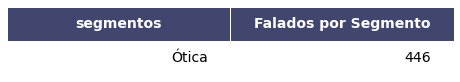

In [39]:
to_contact_segmentos_figure = render_mpl_table(to_contact_segmentos)
to_contact_segmentos.rename(columns={'Falados por Segmento':'faltantes_por_segmento'}, inplace = True)
to_contact_segmentos_figure.figure.savefig('./images/to_contact_segmentos_{}.png'.format(assunto), bbox_inches='tight', pad_inches=0)

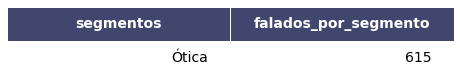

In [40]:
original_dept_figure = render_mpl_table(original_dept)
original_dept.rename(columns={'falados_por_segmento':'total_por_segmento'}, inplace = True)
original_dept_figure.figure.savefig('./images/original_dept_{}.png'.format(assunto), bbox_inches='tight', pad_inches=0)

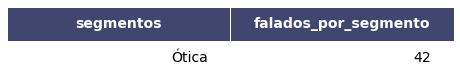

In [41]:
ticket_table_dept_figure = render_mpl_table(ticket_table_dept)
ticket_table_dept_figure.figure.savefig('./images/ticket_table_dept_{}.png'.format(assunto), bbox_inches='tight', pad_inches=0)

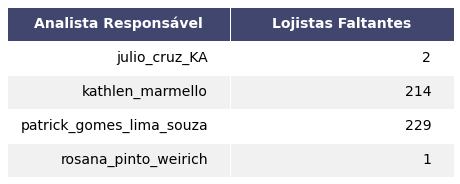

In [42]:
cx_owner_left = base.copy()
cx_owner_left = base.groupby('user_fields_gestor_rentabilizacao').count()
cx_owner_left = cx_owner_left[['client_id']].reset_index()

cx_owner_left.rename(columns={'client_id':
                                             'Lojistas Faltantes',
                                             'user_fields_gestor_rentabilizacao': 'Analista Responsável'}, inplace = True)

cx_owner_initial_figure = render_mpl_table(cx_owner_left)
cx_owner_initial_figure.figure.savefig('./images/cx_owner_left_{}.png'.format(assunto), bbox_inches='tight', pad_inches=0)

In [43]:
cx_owner_table

,cx_owner,tickets_opened
0,julio_pinto_da_silva,16
1,kathlen_marmello,18
2,patrick_gomes_lima_souza,7
3,rosana_pinto_weirich,1


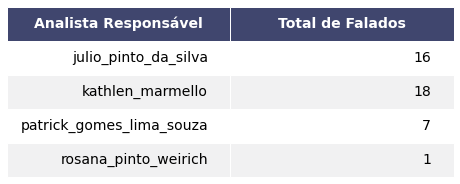

In [44]:
cx_owner_table.rename(columns={'tickets_opened': 'Total de Falados',
                              'cx_owner': 'Analista Responsável'}, inplace = True) # Quantos cada assessor já falou
cx_owner_table_figure = render_mpl_table(cx_owner_table)
cx_owner_table_figure.figure.savefig('./images/cx_owner_table_{}.png'.format(assunto), bbox_inches='tight', pad_inches=0)

In [45]:
ticket_retried.rename(columns={'tickets_retried': 'Retentativas',
                              'cx_owner': 'Analista Responsável'}, inplace = True)

retrial = ticket_retried[['Analista Responsável', 'Retentativas']].groupby('Analista Responsável').sum().reset_index()

#cx_owner_retried_figure = render_mpl_table(retrial) # Quantos cada assessor já falou
#cx_owner_retried_figure.figure.savefig('./images/cx_owner_retried_{}.png'.format(assunto), bbox_inches='tight', pad_inches=0)


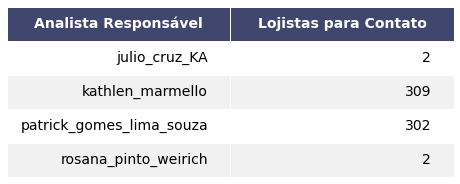

In [46]:
cx_owner_count = cx_owner_count[['client_id']].reset_index()
cx_owner_count.rename(columns={'client_id':
                                             'Lojistas para Contato',
                                             'user_fields_gestor_rentabilizacao': 'Analista Responsável'}, inplace = True)

cx_owner_initial_figure = render_mpl_table(cx_owner_count)
cx_owner_initial_figure.figure.savefig('./images/cx_owner_count_{}.png'.format(assunto), bbox_inches='tight', pad_inches=0, dpi=199)

In [47]:
cx_table = None
cx_table = cx_owner_count.merge(cx_owner_table, on = 'Analista Responsável', how = 'left')
#cx_table = cx_table.merge(retrial, on = 'Analista Responsável', how = 'left')
cx_table = cx_table.merge(cx_owner_left, on = 'Analista Responsável', how = 'left')
cx_table.fillna(0, inplace = True)

cx_table['Total de Falados'] = cx_table['Total de Falados'].astype(int)
#cx_table['Retentativas'] = cx_table['Retentativas'].astype(int)
cx_table['Lojistas Faltantes'] = cx_table['Lojistas Faltantes'].astype(int)
cx_table.rename(columns={'Lojistas para Contato': 'Total Tickets',
                        'Total de Falados': 'Tickets Consumidos',
                        'Lojistas Faltantes': 'Tickets Restantes'}, inplace = True)

#cx_table['Assunto'] = 'marchon_base_historica'
cx_table.loc["Total"] = cx_table.sum()
cx_table['Analista Responsável'].iloc[-1] = 'Total'
pickle.dump( cx_table, open( "./data/cx_table_marchon_base_historica.pickle", "wb" ) )







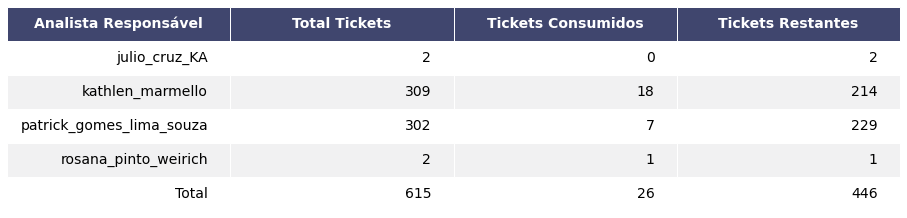

In [48]:
cx_table_figure_marchon_base_historica = render_mpl_table(cx_table) 
cx_table_figure_marchon_base_historica.figure.savefig('./images/cx_table_figure_marchon_base_historica.png', bbox_inches='tight', pad_inches=0, dpi=199)

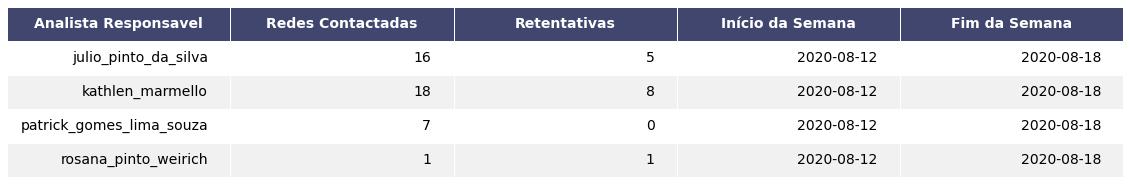

In [49]:

document = Document()

document.add_heading('Dia {} - Report de Tickets'.format(pd.to_datetime('today').strftime("%Y-%m-%d")), 0)


document.add_heading('Assunto: Marchon Base Histórica', level=1)
document.paragraphs[0].text

document.add_paragraph('Número Total de Redes: {}'.format(original_number))

          
          
document.add_paragraph('Redes Contactadas: {}'.format(talked_clients), style='List Number')
document.add_paragraph('Número de Redes Filtradas: {}'.format(already_talked_last_days), style='List Number')
#document.add_paragraph('Número de Lojistas sem Assessor Definido: {}'.format(number_null_emails), style='List Number')
document.add_paragraph('Redes Restantes: {}'.format(to_contact_number), style='List Bullet')


paragraph = document.add_paragraph('Visão Macro')
paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
document.add_picture('./images/cx_table_figure_marchon_base_historica.png', width=Inches(7.1))
last_paragraph = document.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

paragraph = document.add_paragraph('Visão Semana')
paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
for i in range(0, len(tables_list)):
    table = render_mpl_table(tables_list[i]) 
    table.figure.savefig('./images/cx_table_week_{}_marchon_historico.png'.format(i), bbox_inches='tight', pad_inches=0, dpi=199)
    document.add_picture('./images/cx_table_week_{}_marchon_historico.png'.format(i), width=Inches(7.1))
    last_paragraph = document.paragraphs[-1] 
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

document.save('/home/ubuntu/victor_projects/ticket_tracking_remade/reports/marchon_base_historica_report.docx')

In [50]:
talked_clients_marchon_base_historica = talked_clients
pickle.dump( talked_clients_marchon_base_historica, open( "./data/talked_clients_marchon_base_historica.pickle", "wb" ) )

original_number_marchon_base_historica = original_number
pickle.dump( original_number_marchon_base_historica, open( "./data/original_number_marchon_base_historica.pickle", "wb" ) )

to_contact_number_marchon_base_historica = to_contact_number
pickle.dump( to_contact_number_marchon_base_historica, open( "./data/to_contact_number_marchon_base_historica.pickle", "wb" ) )

already_talked_last_days_marchon_base_historica = already_talked_last_days
pickle.dump( already_talked_last_days_marchon_base_historica, open( "./data/already_talked_last_days_marchon_base_historica.pickle", "wb" ) )

number_null_emails_marchon_base_historica = number_null_emails
pickle.dump( number_null_emails_marchon_base_historica, open( "./data/number_null_emails_marchon_base_historica.pickle", "wb" ) )

original_dept_marchon_base_historica = original_dept
pickle.dump( original_dept_marchon_base_historica, open( "./data/original_dept_marchon_base_historica.pickle", "wb" ) )

to_contact_segmentos_marchon_base_historica = to_contact_segmentos
pickle.dump( to_contact_segmentos_marchon_base_historica, open( "./data/to_contact_segmentos_marchon_base_historica.pickle", "wb" ) )

null_emails_segmentos_marchon_base_historica = null_emails_segmentos
pickle.dump( null_emails_segmentos_marchon_base_historica, open( "./data/null_emails_segmentos_marchon_base_historica.pickle", "wb" ) )

last_days_segmento_marchon_base_historica = last_days_segmento
pickle.dump( last_days_segmento_marchon_base_historica, open( "./data/last_days_segmento_marchon_base_historica.pickle", "wb" ) )

ticket_table_dept_marchon_base_historica = ticket_table_dept
pickle.dump( ticket_table_dept_marchon_base_historica, open( "./data/ticket_table_dept_marchon_base_historica.pickle", "wb" ) )

already_talked_segmento_marchon_base_historica = already_talked_segmento
pickle.dump( already_talked_segmento_marchon_base_historica, open( "./data/already_talked_segmento_marchon_base_historica.pickle", "wb" ) )

In [51]:
cx_table = None
cx_table = cx_owner_count.merge(cx_owner_table, on = 'Analista Responsável', how = 'left')
cx_table = cx_table.merge(retrial, on = 'Analista Responsável', how = 'left')
cx_table = cx_table.merge(cx_owner_left, on = 'Analista Responsável', how = 'left')
cx_table.fillna(0, inplace = True)

cx_table['Total de Falados'] = cx_table['Total de Falados'].astype(int)
cx_table['Retentativas'] = cx_table['Retentativas'].astype(int)
cx_table['Lojistas Faltantes'] = cx_table['Lojistas Faltantes'].astype(int)
cx_table.rename(columns={'Lojistas para Contato': 'Total Tickets',
                        'Total de Falados': 'Tickets Consumidos',
                        'Lojistas Faltantes': 'Tickets Restantes'}, inplace = True)

cx_table['Assunto'] = 'marchon_base_historica'

pickle.dump( cx_table, open( "./data/cx_table_marchon_base_historica.pickle", "wb" ) )

In [52]:
segmento_table = None
segmento_table = original_dept_marchon_base_historica.merge(to_contact_segmentos_marchon_base_historica, on = 'segmentos', how = 'left')
segmento_table = segmento_table.merge(ticket_table_dept_marchon_base_historica, on = 'segmentos', how = 'left')
segmento_table = segmento_table.merge(already_talked_segmento_marchon_base_historica, on = 'segmentos', how = 'left')
segmento_table = segmento_table.merge(ticket_retried_segmentos, on = 'segmentos', how = 'left')


segmento_table.fillna(0, inplace = True)
segmento_table['falados_por_segmento'] = segmento_table['falados_por_segmento'].astype(int)
segmento_table['filtrados_por_segmento'] = segmento_table['filtrados_por_segmento'].astype(int)
segmento_table['Retentativas'] = segmento_table['Retentativas'].astype(int)
segmento_table['Assunto'] = 'Marchon Base Histórica'

segmento_table.rename(columns={'total_por_segmento': 'Total Tickets',
                                'total_por_segmento': 'Tickets Restantes',
                              'falados_por_segmento': 'Tickets Consumidos',
                              'filtrados_por_segmento': 'Tickets Negativados'}, inplace = True)

pickle.dump( segmento_table, open( "./data/segmento_table_marchon_base_historica.pickle", "wb" ) )